# Reproduce the models in paper 32

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pickle

## Read filtered MIMIC-III Dataset

In [4]:
# {'4280': g1_pids, '4019': g2_pids, '5849': g3_pids}
pids = pickle.load(open('dataset/t1/pids.pkl', 'rb'))
group_pids = pickle.load(open('dataset/t1/group_pids.pkl', 'rb'))
seqs = pickle.load(open('dataset/t1/seqs.pkl', 'rb'))
rtypes = pickle.load(open('dataset/t1/rtypes.pkl', 'rb'))

pids = np.array(pids)

In [5]:
print(len(pids))
print(len(seqs))
print(seqs[3])

897
897
[[121, 14, 122, 52, 72, 137, 491, 492, 126, 30, 7, 146, 493, 61, 53, 250, 11, 494, 249], [495, 250, 95, 72, 14, 399, 137, 80, 146, 61, 125, 53, 155, 101, 496, 274, 299], [121, 122, 72, 430, 71, 259, 312, 51, 175], [415, 14, 497, 72, 399, 53, 146, 166, 71, 498, 164, 499, 500, 68, 125]]


In [6]:
group1_pids = group_pids['4280']
group2_pids = group_pids['4019']
group3_pids = group_pids['5849']

In [7]:
c1_set = set(group1_pids)
c2_set = set(group2_pids)
c3_set = set(group3_pids)

print(len(list(c1_set.intersection(c2_set))))
print(len(list(c2_set.intersection(c3_set))))
print(len(list(c3_set.intersection(c1_set))))
print(len(list(c1_set.intersection(c2_set, c3_set))))

0
0
0
0


In [8]:
# max visit
num_visit = [len(patient) for patient in seqs]
max_visit = max(num_visit)
max_visit

42

### Basic details about the dataset

In [9]:
print("Total sequences: {}".format(len(seqs)))
print("Number of patients in group 1: {}".format(len(group1_pids)))
print("Number of patients in group 2: {}".format(len(group2_pids)))
print("Number of patients in group 3: {}".format(len(group3_pids)))

Total sequences: 897
Number of patients in group 1: 257
Number of patients in group 2: 295
Number of patients in group 3: 345


In [10]:
unique_codes = []
for patient in seqs:
    for visit in patient:
        for code in visit:
            unique_codes.append(code)
unique_codes = list(set(unique_codes))
unique_codes = sorted(unique_codes)
print(len(unique_codes))

2835


### Filter events
Remove the events that occur outside the observation window. That is, all events in visits before a disease diagnosis.

diagnosis -> index\
DIAG_4280 -> 53\
DIAG_4019 -> 29\
DIAG_5849 -> 32

In [11]:
observation_seqs = []
for patient in seqs:
    obs_index = 3
    for visit in patient[3:]:
        visit_set = set(visit)
        if 32 in visit_set:
            break
        if 29 in visit_set:
            break
        if 53 in visit_set:
            break
        
        obs_index += 1
    observation_seqs.append(patient[:obs_index])

In [12]:
# Count new max visit
num_obs_visit = [len(patient) for patient in observation_seqs]
max_obs_visit = max(num_obs_visit)
print(max_obs_visit)

obs_unique_codes = []
for patient in observation_seqs:
    for visit in patient:
        for code in visit:
            obs_unique_codes.append(code)
obs_unique_codes = list(set(obs_unique_codes))
obs_unique_codes = sorted(obs_unique_codes)
print(len(obs_unique_codes))

23
2450


### Remap unique codes that contain codes in the observational phrase

In [13]:
code2obscode = {}
obscode2code = {}
for idx, old_code in enumerate(obs_unique_codes):
    code2obscode[old_code] = idx
    obscode2code[idx] = old_code

### Generate Training, Test, Valid splits
as well as generate data pair for similarity training

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
pids_label = []
for p_id in pids:
    tt = 0
    if p_id in group1_pids:
        pids_label.append(4280)
        tt += 1
    if p_id in group2_pids:
        pids_label.append(4019)
        tt += 1
    if p_id in group3_pids:
        pids_label.append(5849)
        tt += 1
    if tt > 1:
        print(p_id)
    
pids_label = np.array(pids_label)
print(len(pids_label))

897


In [16]:
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15
train, test, train_y, test_y = train_test_split(observation_seqs, pids_label, test_size=1-train_ratio, random_state=12345)
val, test, val_y, test_y = train_test_split(test, test_y, test_size=test_ratio/(test_ratio+val_ratio), random_state=12345)
print('Train: {}, Validation: {}, Test: {}'.format(len(train), len(val), len(test)))

Train: 672, Validation: 90, Test: 135


### Training Pair?
Anchor, positive, and negative

where the anchor and the positive have the same class labels and the negative has the different class label

## Build the dataset

In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [18]:
class CustomDataset(Dataset):
    def __init__(self, seqs, labels):
        self.x = seqs
        self.y = labels
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        # self.y contains the class of a patient, either 4280, 4019, 5849
        return self.x[index], self.y[index]

In [19]:
train_dataset = CustomDataset(train, train_y)
test_dataset = CustomDataset(test, test_y)

### Collate Function 

In [20]:
def collate_fn(data):
    '''
    Collate the the list of samples into batches.
    pad the diagnosis sequences to the sample shape (max # visits, len(freq_codes))
    '''
    sequences, labels = zip(*data)
    
    y = torch.tensor(labels, dtype=torch.float)
    
    num_patients = len(sequences)
    #num_visits = [len(patient) for patient in sequences]
    #max_num_visits = max(num_visits)
    
    x = torch.zeros((num_patients, max_obs_visit, len(obs_unique_codes)), dtype=torch.float)
    
    for p_idx, patient in enumerate(sequences):
        for v_idx, visit in enumerate(patient):
            for code in visit:
                x[p_idx][v_idx][code2obscode[code]] = 1
    
    return x, y

In [21]:
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, collate_fn=collate_fn, shuffle=False)

train_loader_iter = iter(train_loader)
x_i, y_i = next(train_loader_iter)
print(x_i[0])
print(x_i.shape)
print(y_i[0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([16, 23, 2450])
tensor(4280.)


### Triplet Dataset

In [22]:
class TripletDataset(Dataset):
    def __init__(self, seqs, labels):
        self.x = seqs
        self.y = labels # this is label
        self.y_set = set(self.y)
        
        self.y2indice = {y: np.where(self.y == y)[0] for y in self.y}
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        # self.y contains the class of a patient, either 4280, 4019, 5849
        '''
        Outputs:
            a sample for positive, anchor, negative
        '''
        y = self.y[index]
        
        random_state = np.random.RandomState(12345)
        anc = self.x[index]
        anc_y = self.y[index]
        
        pos_index = index
        while pos_index == index:
            # re hash an index untill pos sample is different than neg sample
            pos_index = np.random.choice(self.y2indice[anc_y])
        neg_label = np.random.choice(list(self.y_set - set([anc_y]))) # pick a class for a negative example
        neg_index = np.random.choice(self.y2indice[neg_label])
        pos = self.x[pos_index]
        neg = self.x[neg_index]
        return (pos, anc, neg), y

In [23]:
triple_train_dataset = TripletDataset(train, train_y)
triple_test_dataset  = TripletDataset(test, test_y)

### Collate Function for Triplet

In [24]:
def collate_fn_triplet(batch):
    '''
    Collate the the list of samples into batches.
    pad the diagnosis sequences to the sample shape (max # visits, len(freq_codes))
    '''
    # print(len(batch))
    
    # different length
    pan, y = zip(*batch) # pan -> positive, anchor, negative
    
    num_batch = len(batch)
    
    p = torch.zeros((num_batch, max_obs_visit, len(obs_unique_codes)), dtype=torch.float)
    a = torch.zeros((num_batch, max_obs_visit, len(obs_unique_codes)), dtype=torch.float)
    n = torch.zeros((num_batch, max_obs_visit, len(obs_unique_codes)), dtype=torch.float)
    
    for p_idx, patient in enumerate(pan):
        pos, anc, neg = patient
        for v_idx, visit in enumerate(pos):
            for code in visit:
                p[p_idx][v_idx][code2obscode[code]] = 1
        for v_idx, visit in enumerate(anc):
            for code in visit:
                a[p_idx][v_idx][code2obscode[code]] = 1
        for v_idx, visit in enumerate(neg):
            for code in visit:
                n[p_idx][v_idx][code2obscode[code]] = 1
    
    return (p, a, n), y

In [25]:
triplet_train_loader = DataLoader(triple_train_dataset, batch_size=16, collate_fn=collate_fn_triplet, shuffle=True)
triplet_test_loader  = DataLoader(triple_test_dataset,  batch_size=16, collate_fn=collate_fn_triplet, shuffle=False)
triplet_train_loader_iter = iter(triplet_train_loader)
pan_i, y_i = next(triplet_train_loader_iter)
p_i, a_i, n_i = pan_i
print(len(p_i))

16


## Visualizing Raw Patient Data

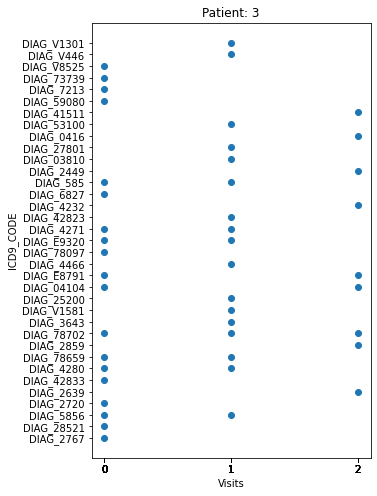

In [26]:
p_sample_id = 3
p_sample = observation_seqs[p_sample_id]
xx = []
yy_code = []
for idx, visit in enumerate(p_sample):
    for code in visit:
        yy_code.append(code)
        xx.append(idx)
yy_code = list(set(yy_code))
yy_code = sorted(yy_code)


yy = []
for visit in p_sample:
    for code in visit:
        yy.append(yy_code.index(code))

yy_labels = []
for item in yy_code:
    yy_labels.append(rtypes[obscode2code[item]])
yy_labels_idx = list(range(len(yy_labels)))

plt.figure(figsize=(5,8))
plt.scatter(xx, yy)
plt.xticks(xx, xx)
plt.yticks(yy_labels_idx, yy_labels)
plt.xlabel('Visits')
plt.ylabel('ICD9_CODE')
plt.title('Patient: {}'.format(p_sample_id))
plt.show()

### 2.1 Visit Embedding

v_i should be a multi-hot vector representation

In [27]:
class VisitEmbedding(torch.nn.Module):
    def __init__(self, vocab_code, emb_dim=16):
        super(VisitEmbedding, self).__init__()
        # emb_dim < vocab_code
        self.vocab_code = vocab_code # unique medical codes
        self.emb_dim    = emb_dim
        
        self.fc   = nn.Linear(self.vocab_code, self.emb_dim, bias=True) # bias, True
        self.relu = nn.ReLU()

    
    def forward(self, visits):
        # should return an embedding matrix
        # visits: a multi-hot vector (batch size, max_visit, vocab_code)

        x = self.fc(visits)
        x = self.relu(x)
        return x

### 2.2 Patient Embedding

In [28]:
# p different filter sizes
# the number of filters per size is q
# total number of filters is m = pq, output m feature maps
# h is a window size of visit length (e.g. 100 patient -> 7)
# with stride equal 1
# pooled outputs forms a vector represention h

Create a vector represention that encodes the relationship across ajacent time points by using CNN.

Calculate the output volume for a convolutional layer: given the input volume size $W$, the kernel/filter size $F$, the stride $S$, and the amount of zero padding $P$ used on the border, calculate the output volume size.

Checkout: https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29
To find out filter and output dim

In [29]:
class VectorCNN(torch.nn.Module):
    def __init__(self, emb_dim=16):
        super(VectorCNN, self).__init__()
        # 1D CNN, 1D CNN, 1D CNN
        # model parameters
        self.emb_dim = emb_dim # input size
        self.out_dim = 48 # Number of channels produced by the convolution
        self.filter  = 3  # kernel/filter size
        self.stride  = 1  # according by the paper
        self.padding = 0  # NOTE: will zero cause an issue of information loss?
        
        # networks
        self.patient_emb = VisitEmbedding(vocab_code=len(obs_unique_codes), emb_dim=emb_dim)
        self.cnn_1d  = nn.Conv1d(in_channels=self.emb_dim,
                                 out_channels=self.out_dim,
                                 kernel_size=self.filter,
                                 stride=self.stride,
                                 padding=self.padding)
        self.relu    = nn.ReLU()
        self.pool_1d = nn.MaxPool1d(kernel_size=self.filter)
        
        
    def forward(self, patient):
        # return a learned vector h
        
        patient_embedding = self.patient_emb(patient) # (batch size, visit, features of diagnosis)
        patient_embedding = patient_embedding.permute((0, 2, 1)) # (batch size, features of diagnosis, visit)
        out = self.cnn_1d(patient_embedding) 
        out = self.relu(out) # produce a feature map c, correspond to the paper description
        out = self.pool_1d(out)
        out = out.view(len(out), -1) # pooled outputs from all the filters are concatenated to form a vector
        return out

## Simularity Learning

### 3.1 Predictive Similarity Learning - Irreproducible!!!

#### Existing technicalities
1. What is bilinear distance S = h_i M h_j
    - assume M is known, Mahalanobis distance
        - http://contrib.scikit-learn.org/metric-learn/introduction.html
    - unknows: W_h, what is W_h???
    - assume h_i, h_j is from the learned vector h, produced by 1D CNN layers
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html?highlight=mahalanobis#scipy.spatial.distance.mahalanobis
2. How to construct triplet, a postive example, a negative example, an anchor
    - known: FaceNet paper discussed how to pick a reasonable triple for training
    - https://github.com/adambielski/siamese-triplet/blob/master/datasets.py
3. Unknow hypterparameter of CNN layers

In [30]:
similarity_loss = nn.CrossEntropyLoss()

In [31]:
class PredictiveSimilarity(torch.nn.Module):
    def __init__(self):
        super(PredictiveSimilarity, self).__init__()
        # define a M symmetric matrix
        # M: (m, m), where is m = pq (m feature maps)
    def forward(self, learned_vector_h):
        out = None
        return out

### 3.2 Triplet-Loss Metric Learning Network

In [32]:
class TripletNetwork(torch.nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        # a network work presented in Section III-A
        self.vector_learning = VectorCNN(emb_dim=32)
    
    def get_learned_vector(self, x):
        return self.vector_learning(x)
        
    def forward(self, pos, anc, neg):
        p = self.vector_learning(pos)
        a = self.vector_learning(anc)
        n = self.vector_learning(neg)
        return p, a, n

## Triplet Model Training

In [33]:
#cuda = True if torch.cuda.is_available() else False
#Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [34]:
triplet_model = TripletNetwork()

lr = 1e-3
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=lr)
criterion = nn.TripletMarginLoss(margin=1, p=2)

In [35]:
n_epochs = 20

for epoch in range(n_epochs):
    triplet_model.train()

    train_loss = 0

    for pan, y in triplet_train_loader:
        pos, anc, neg = pan
        optimizer.zero_grad()
        p, a, n = triplet_model(pos, anc, neg)
        loss = criterion(a, p, n)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    train_loss = train_loss / len(triplet_train_loader)
    print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	 Training Loss: 0.991892
Epoch: 2 	 Training Loss: 0.940269
Epoch: 3 	 Training Loss: 0.797727
Epoch: 4 	 Training Loss: 0.682578
Epoch: 5 	 Training Loss: 0.585928
Epoch: 6 	 Training Loss: 0.507791
Epoch: 7 	 Training Loss: 0.445580
Epoch: 8 	 Training Loss: 0.378942
Epoch: 9 	 Training Loss: 0.265238
Epoch: 10 	 Training Loss: 0.198486
Epoch: 11 	 Training Loss: 0.170793
Epoch: 12 	 Training Loss: 0.128204
Epoch: 13 	 Training Loss: 0.086172
Epoch: 14 	 Training Loss: 0.045702
Epoch: 15 	 Training Loss: 0.054405
Epoch: 16 	 Training Loss: 0.039730
Epoch: 17 	 Training Loss: 0.018742
Epoch: 18 	 Training Loss: 0.023841
Epoch: 19 	 Training Loss: 0.019687
Epoch: 20 	 Training Loss: 0.035577


In [40]:
# ref: https://github.com/adambielski/siamese-triplet
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 336))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for pan, target in dataloader:
            pos, anc, neg = pan
            embeddings[k:k+len(anc)] = model.get_learned_vector(anc).data.cpu().numpy()
            labels[k:k+len(anc)] = np.array(target)
            k += len(anc)
    return embeddings, labels

In [41]:
train_embeddings_tl, train_labels_tl = extract_embeddings(triplet_train_loader, triplet_model)
test_embeddings_tl, test_labels_tl   = extract_embeddings(triplet_test_loader, triplet_model)

### K Nearest Neighbor to predict patients' similarity/risk

In [44]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import metrics
from sklearn.metrics.cluster import rand_score, normalized_mutual_info_score

In [49]:
# ref: Purity: https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [50]:
knn_emb = KNeighborsClassifier(n_neighbors=5)
knn_emb.fit(train_embeddings_tl, train_labels_tl)

KNeighborsClassifier()

### Evaluate the triplet model

In [51]:
baseline_k = 5

In [52]:
test_preds = []
for ii, test_i in enumerate(test_embeddings_tl):
    test_i = test_i.reshape((1, -1))
    d, idx = knn_emb.kneighbors(test_i)
    # print('Ground Truth Label: {}'.format(test_labels_tl[ii]))
    unique, counts = np.unique(train_labels_tl[idx].astype(int), return_counts=True)
    test_preds.append(unique[0]) # first elem with the most count

print('CNN Triplet (K={}), Accuracy: {}'.format(baseline_k, accuracy_score(test_labels_tl, test_preds)))
print('CNN Triplet (K={}), Recall: {}'.format(baseline_k, recall_score(test_labels_tl, test_preds, average='macro')))
print('CNN Triplet (K={}), Precision: {}'.format(baseline_k, precision_score(test_labels_tl, test_preds, average='macro')))
print('CNN Triplet (K={}), F1 Score: {}'.format(baseline_k, f1_score(test_labels_tl, test_preds, average='macro')))
print('CNN Triplet (K={}), RI: {}'.format(baseline_k, rand_score(test_labels_tl, test_preds)))
print('CNN Triplet (K={}), Purity: {}'.format(baseline_k, purity_score(test_labels_tl, test_preds)))
print('CNN Triplet (K={}), NMI: {}'.format(baseline_k, normalized_mutual_info_score(test_labels_tl, test_preds)))

CNN Triplet (K=5), Accuracy: 0.5259259259259259
CNN Triplet (K=5), Recall: 0.5198135198135199
CNN Triplet (K=5), Precision: 0.5191358024691358
CNN Triplet (K=5), F1 Score: 0.5191717899795067
CNN Triplet (K=5), RI: 0.5988944168048645
CNN Triplet (K=5), Purity: 0.5259259259259259
CNN Triplet (K=5), NMI: 0.09968024619605426


### Use k-mean for patient clustering

In [53]:
kmeans_emb = KMeans(n_clusters=3, random_state=12345).fit(train_embeddings_tl, train_labels_tl)

In [54]:
print(kmeans_emb.labels_[:10])
print(train_labels_tl[:10])

[0 0 0 1 2 2 0 0 0 0]
[5849. 5849. 5849. 4019. 4280. 4280. 5849. 5849. 5849. 5849.]


In [55]:
kmeans_emb_pred = kmeans_emb.predict(test_embeddings_tl)

In [56]:
test_kmean_label = []
for item in test_labels_tl:
    if int(item) == 5849:
        test_kmean_label.append(2)
    if int(item) == 4280:
        test_kmean_label.append(0)
    if int(item) == 4019:
        test_kmean_label.append(1)

In [57]:
print('Triplet (K={}), RI: {}'.format(3, rand_score(test_kmean_label, kmeans_emb_pred)))
print('Triplet (K={}), Purity: {}'.format(3, purity_score(test_kmean_label, kmeans_emb_pred)))
print('Triplet (K={}), NMI: {}'.format(3, normalized_mutual_info_score(test_kmean_label, kmeans_emb_pred)))

Triplet (K=3), RI: 0.5438363736871199
Triplet (K=3), Purity: 0.45185185185185184
Triplet (K=3), NMI: 0.04187411162148437


In [58]:
from sklearn.decomposition import PCA

In [59]:
pca = PCA(2)
transformed_emb = pca.fit_transform(test_embeddings_tl)

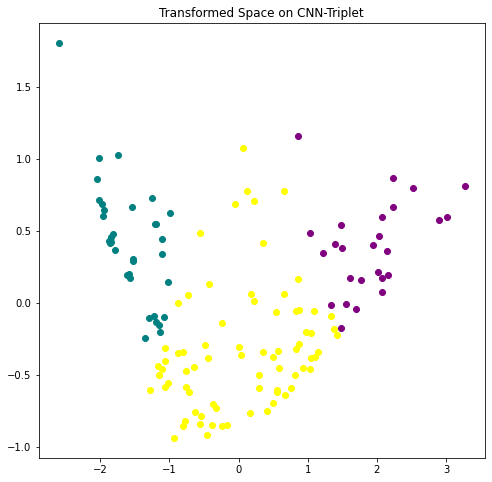

In [60]:
filtered_label0 = transformed_emb[kmeans_emb_pred == 0]
filtered_label1 = transformed_emb[kmeans_emb_pred == 1]
filtered_label2 = transformed_emb[kmeans_emb_pred == 2]
plt.figure(figsize=(8,8))
plt.title("Transformed Space on CNN-Triplet")
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='yellow')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='teal')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color='purple')
plt.show()

In [63]:
knn_train_x = []
knn_train_y = []
for x_i, y_i in train_loader:
    x_i = x_i.view(len(x_i), -1)
    knn_train_x.append(x_i)
    knn_train_y.append(y_i)
    
knn_train_x = torch.cat(knn_train_x, dim=0)
knn_train_y = torch.cat(knn_train_y, dim=0)
print(knn_train_x.size())

knn_test_x = []
knn_test_y = []
for x_i, y_i in test_loader:
    x_i = x_i.view(len(x_i), -1)
    knn_test_x.append(x_i)
    knn_test_y.append(y_i)
    
knn_test_x = torch.cat(knn_test_x, dim=0)
knn_test_y = torch.cat(knn_test_y, dim=0)
print(knn_test_x.size())

torch.Size([672, 56350])
torch.Size([135, 56350])


### k-nearest neighbors, k=3

In [64]:
kmeans_euc      = KMeans(n_clusters=3, random_state=12345).fit(knn_train_x, knn_train_y)
kmeans_euc_pred = kmeans_euc.predict(knn_test_x)

In [65]:
# map new ground truth label
# not useful
test_knn_label = []
for item in knn_test_y:
    if int(item) == 5849:
        test_knn_label.append(2)
    if int(item) == 4280:
        test_knn_label.append(0)
    if int(item) == 4019:
        test_knn_label.append(1)
        
print('Triplet (K={}), RI: {}'.format(3, rand_score(test_knn_label, kmeans_euc_pred)))
print('Triplet (K={}), Purity: {}'.format(3, purity_score(test_knn_label, kmeans_euc_pred)))
print('Triplet (K={}), NMI: {}'.format(3, normalized_mutual_info_score(test_knn_label, kmeans_euc_pred)))

Triplet (K=3), RI: 0.5774461028192371
Triplet (K=3), Purity: 0.4740740740740741
Triplet (K=3), NMI: 0.058591986489670775


## 1 Baseline models
k-means, k=3
GMML, LMNN, ITML, CNN_tripplet

Euclidean and Cosine distances on raw inputs, without mapping parameter to be learning

### 1.2 KNN using Euclidean Distance
ref: https://medium.com/analytics-vidhya/a-beginners-guide-to-knn-and-mnist-handwritten-digits-recognition-using-knn-from-scratch-df6fb982748a

In [66]:
model = KNeighborsClassifier(n_neighbors=baseline_k, metric="euclidean")
model.fit(knn_train_x, knn_train_y)

knn_test_pred = model.predict(knn_test_x)
accuracy = accuracy_score(knn_test_y, knn_test_pred)
print('Euclidean Distance (K={}), Accuracy: {}'.format(baseline_k, accuracy))
print('Euclidean Distance (K={}), Recall: {}'.format(baseline_k, recall_score(knn_test_y, knn_test_pred, average='macro')))
print('Euclidean Distance (K={}), Precision: {}'.format(baseline_k, precision_score(knn_test_y, knn_test_pred, average='macro')))
print('Euclidean Distance (K={}), F1 Score: {}'.format(baseline_k, f1_score(knn_test_y, knn_test_pred, average='macro')))
print('Euclidean Distance (K={}), RI: {}'.format(baseline_k, rand_score(knn_test_y, knn_test_pred)))
print('Euclidean Distance (K={}), Purity: {}'.format(baseline_k, purity_score(knn_test_y, knn_test_pred)))
print('Euclidean Distance (K={}), NMI: {}'.format(baseline_k, normalized_mutual_info_score(knn_test_y, knn_test_pred)))

Euclidean Distance (K=5), Accuracy: 0.37037037037037035
Euclidean Distance (K=5), Recall: 0.3830613830613831
Euclidean Distance (K=5), Precision: 0.406006006006006
Euclidean Distance (K=5), F1 Score: 0.299294252828538
Euclidean Distance (K=5), RI: 0.4435599778883361
Euclidean Distance (K=5), Purity: 0.4074074074074074
Euclidean Distance (K=5), NMI: 0.025192253540854418


In [67]:
transformed_euc = pca.fit_transform(knn_test_x)

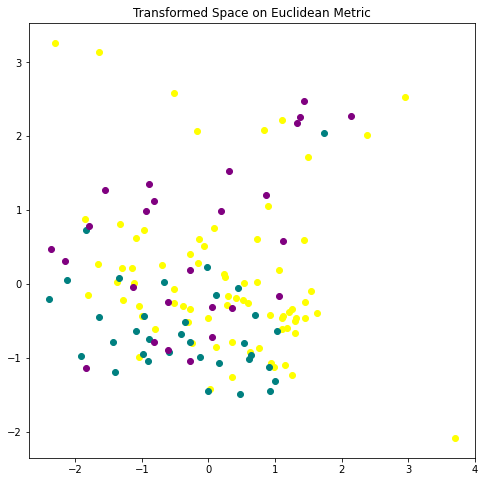

In [68]:
filtered_label0 = transformed_euc[kmeans_emb_pred == 0]
filtered_label1 = transformed_euc[kmeans_emb_pred == 1]
filtered_label2 = transformed_euc[kmeans_emb_pred == 2]
plt.figure(figsize=(8,8))
plt.title("Transformed Space on Euclidean Metric")
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='yellow')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='teal')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color='purple')
plt.show()

### 1.3 KNN using Cosine Distance

In [69]:
model = KNeighborsClassifier(n_neighbors=baseline_k, metric="cosine")
model.fit(knn_train_x, knn_train_y)

knn_test_pred = model.predict(knn_test_x)
accuracy = accuracy_score(knn_test_y, knn_test_pred)
print('Cosine Distance (K={}), Accuracy: {}'.format(baseline_k, accuracy))
print('Cosine Distance (K={}), Recall: {}'.format(baseline_k, recall_score(knn_test_y, knn_test_pred, average='macro')))
print('Cosine Distance (K={}), Precision: {}'.format(baseline_k, precision_score(knn_test_y, knn_test_pred, average='macro')))
print('Cosine Distance (K={}), F1 Score: {}'.format(baseline_k, f1_score(knn_test_y, knn_test_pred, average='macro')))
print('Cosine Distance (K={}), RI: {}'.format(baseline_k, rand_score(knn_test_y, knn_test_pred)))
print('Cosine Distance (K={}), Purity: {}'.format(baseline_k, purity_score(knn_test_y, knn_test_pred)))
print('Cosine Distance (K={}), NMI: {}'.format(baseline_k, normalized_mutual_info_score(knn_test_y, knn_test_pred)))

Cosine Distance (K=5), Accuracy: 0.4
Cosine Distance (K=5), Recall: 0.4104506604506604
Cosine Distance (K=5), Precision: 0.408662613981763
Cosine Distance (K=5), F1 Score: 0.39396243291592126
Cosine Distance (K=5), RI: 0.5480375898286346
Cosine Distance (K=5), Purity: 0.4148148148148148
Cosine Distance (K=5), NMI: 0.016225597564083517


### Aggregated Vector Representation

In [70]:
knn_aggr_train_x = []
knn_aggr_train_y = []
for x_i, y_i in train_loader:
    x_i = x_i.sum(dim=1)
    knn_aggr_train_x.append(x_i)
    knn_aggr_train_y.append(y_i)
    
knn_aggr_train_x = torch.cat(knn_aggr_train_x, dim=0)
knn_aggr_train_y = torch.cat(knn_aggr_train_y, dim=0)
print('knn_aggr_train_x: {}'.format(knn_aggr_train_x.size()))

knn_aggr_test_x = []
knn_aggr_test_y = []
for x_i, y_i in test_loader:
    x_i = x_i.sum(dim=1)
    knn_aggr_test_x.append(x_i)
    knn_aggr_test_y.append(y_i)
    
knn_aggr_test_x = torch.cat(knn_aggr_test_x, dim=0)
knn_aggr_test_y = torch.cat(knn_aggr_test_y, dim=0)
print('knn_aggr_test_x: {}'.format(knn_aggr_test_x.size()))

knn_aggr_train_x: torch.Size([672, 2450])
knn_aggr_test_x: torch.Size([135, 2450])


### 1.4 KNN using Mahalanobis Distance - Failed!

In [71]:
# ITML: Mahalanobis Distance
knn_aggr_train_x_cov = np.cov(knn_aggr_train_x, rowvar=False)
knn_aggr_train_x_cov_inv = np.linalg.inv(knn_aggr_train_x_cov)

model = KNeighborsClassifier(n_neighbors=baseline_k, metric="mahalanobis", metric_params={'VI': knn_aggr_train_x_cov_inv})
model.fit(knn_aggr_train_x, knn_aggr_train_y)

knn_test_pred = model.predict(knn_aggr_test_x)
accuracy = accuracy_score(knn_aggr_test_y, knn_test_pred)
print('Euclidean Distance, K={}, Accuracy: {}'.format(k, accuracy))

LinAlgError: Singular matrix

### Create train and test triplets for baseline models

In [72]:
knn_triplet_train_x = []
knn_triplet_train_y = []
for pan, y in triplet_train_loader:
    pos, anc, neg = pan
    pos = pos.sum(dim=1).unsqueeze(1)
    anc = anc.sum(dim=1).unsqueeze(1)
    neg = neg.sum(dim=1).unsqueeze(1)
    
    combine = torch.cat((pos, anc, neg), 1)
    knn_triplet_train_x.append(combine)
    knn_triplet_train_y.append(torch.tensor(y))

knn_triplet_train_x = torch.cat(knn_triplet_train_x, dim=0)
knn_triplet_train_y = torch.cat(knn_triplet_train_y, dim=0)

print('knn_triplet_train_x: {}'.format(knn_triplet_train_x.size()))
print('knn_triplet_train_y: {}'.format(knn_triplet_train_y.size()))

knn_triplet_test_x = []
knn_triplet_test_y = []
for pan, y in triplet_test_loader:
    pos, anc, neg = pan
    pos = pos.sum(dim=1).unsqueeze(1)
    anc = anc.sum(dim=1).unsqueeze(1)
    neg = neg.sum(dim=1).unsqueeze(1)
    
    combine = torch.cat((pos, anc, neg), 1)
    knn_triplet_test_x.append(combine)
    knn_triplet_test_y.append(torch.tensor(y))

knn_triplet_test_x = torch.cat(knn_triplet_test_x, dim=0)
knn_triplet_test_y = torch.cat(knn_triplet_test_y, dim=0)

print('knn_triplet_test_x: {}'.format(knn_triplet_test_x.size()))
print('knn_triplet_test_y: {}'.format(knn_triplet_test_y.size()))

knn_triplet_train_x: torch.Size([672, 3, 2450])
knn_triplet_train_y: torch.Size([672])
knn_triplet_test_x: torch.Size([135, 3, 2450])
knn_triplet_test_y: torch.Size([135])


### 1.5 SCML - unable to train

In [ ]:
from metric_learn import LMNN, SCML, SCML_Supervised

### 1.6 LMNN - failed, no prediction

In [ ]:
lmnn = LMNN(k=3, min_iter=5, max_iter=10, learn_rate=1e-6)
lmnn.fit(knn_aggr_train_x, knn_aggr_train_y)

#knn_test_pred = lmnn.predict(knn_aggr_test_x)
#accuracy = accuracy_score(knn_aggr_test_y, knn_test_pred)
#print('LMNN, K={}, Accuracy: {}'.format(k, accuracy))